# Business Problem

**Iyzico** is a financial technology company that facilitates the online shopping experience for both buyers and sellers. It provides payment infrastructure for e-commerce companies, marketplaces and individual users. For the last 3 months of 2020, it is expected to make an estimation of the total trading volume on merchant_id and day basis.

# Importing Libraries

**Variables**

* Transaction : Number of transactions
* MerchantID : IDs of merchants
* Paid Price : Payment amount

In [61]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


In [62]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
from pandas_profiling import ProfileReport
import sweetviz as sv

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [63]:
def check_df(dataframe, head=10):
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Variables #####################")
    print(dataframe.columns)
    print("##################### Descriptive Stats #####################")
    print(dataframe.describe().T)
    print("##################### Null Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Info #####################")
    print(dataframe.info())

In [64]:
df = pd.read_csv('/kaggle/input/iyzico-data/iyzico_data.csv', parse_dates=['transaction_date'])
df = df.iloc[:,0:]

In [65]:
check_df(df)

##################### Head #####################
  transaction_date  merchant_id  Total_Transaction  Total_Paid
0       2018-01-01          535                349   25883.226
1       2018-01-01        42616                141   40918.860
2       2018-01-01        46774                410  306902.700
3       2018-01-01        86302                 10      11.340
4       2018-01-01       124381                285  111383.766
5       2018-01-01       129316                  5      15.750
6       2018-01-02          535                729   60263.928
7       2018-01-02        42616                162   48332.772
8       2018-01-02        46774               1708 1431591.822
9       2018-01-02        86302                 83     144.774
##################### Variables #####################
Index(['transaction_date', 'merchant_id', 'Total_Transaction', 'Total_Paid'], dtype='object')
##################### Descriptive Stats #####################
                     count       mean        std

# EDA

In [66]:
profile = ProfileReport(df, title="Pandas Profiling Report")
# profile.to_widgets()
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |          | [  0%]   00:00 -> (? left)


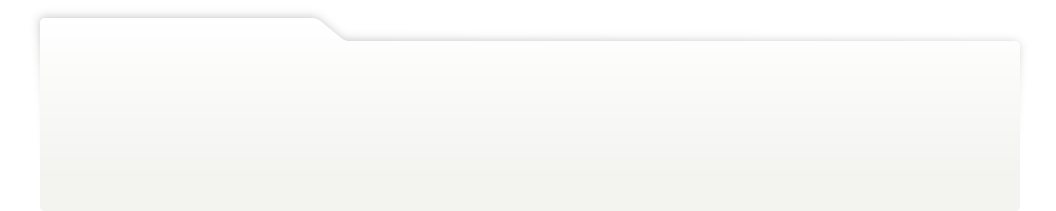
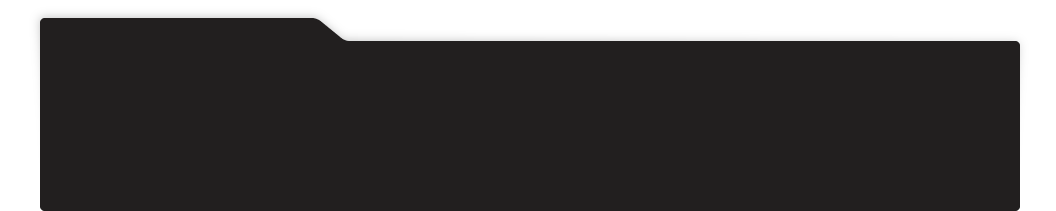
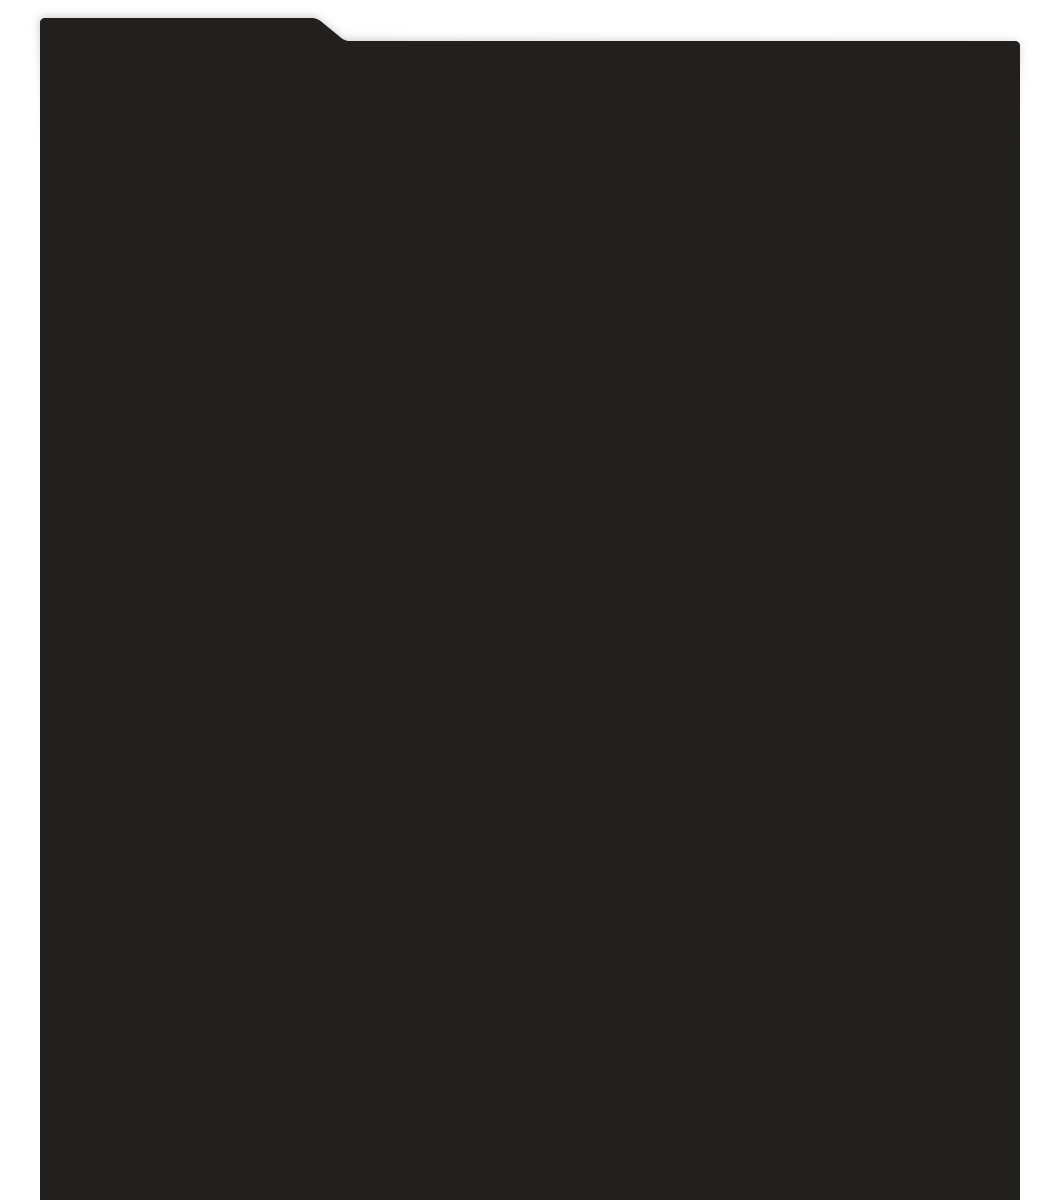
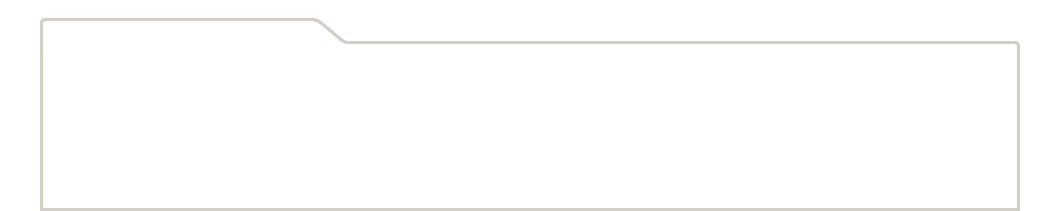
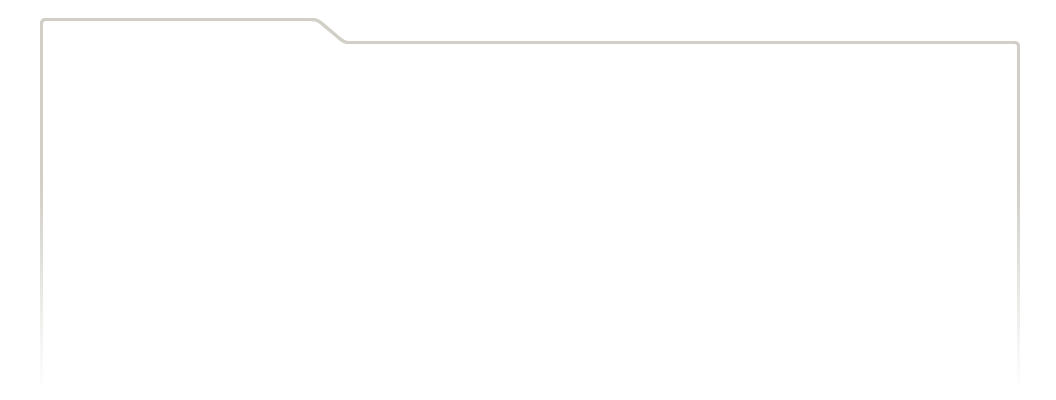
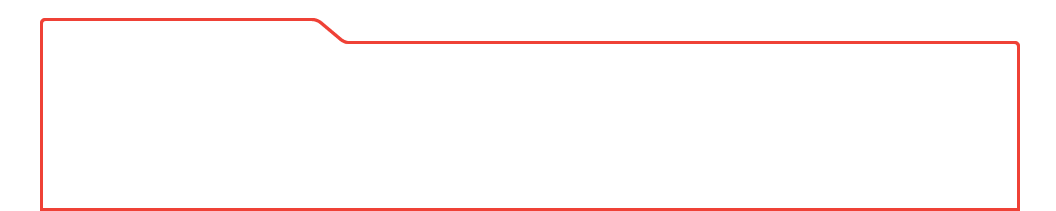
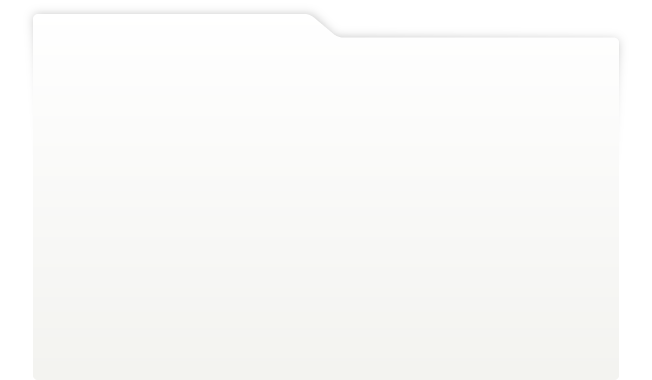
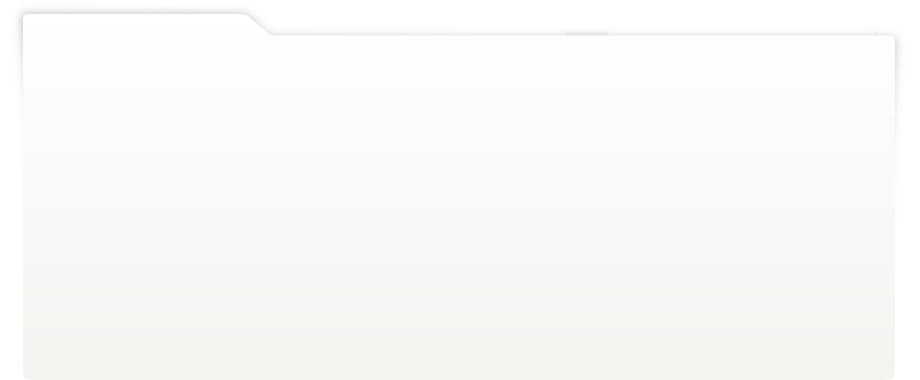
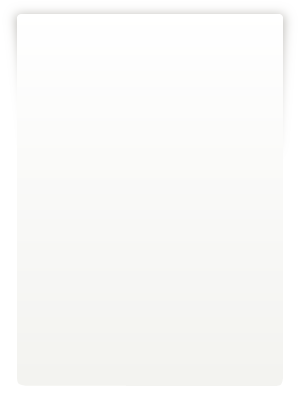
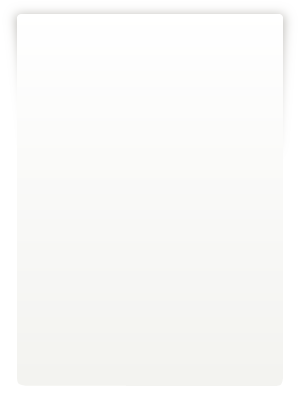
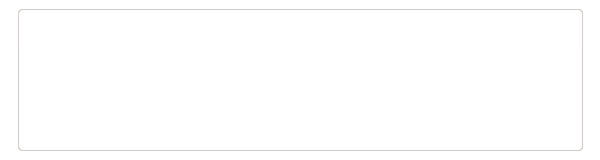
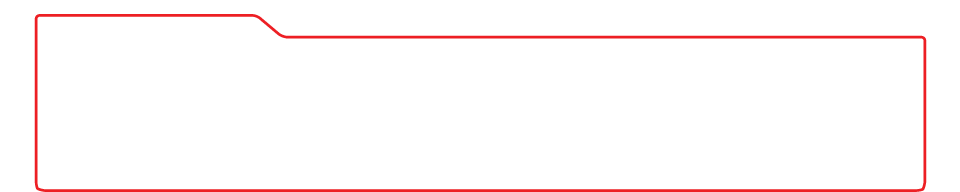
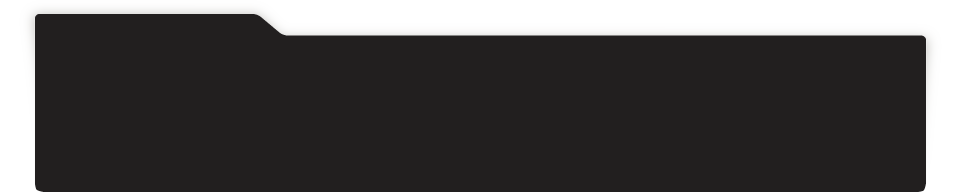
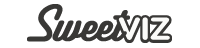
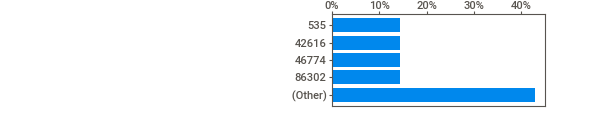
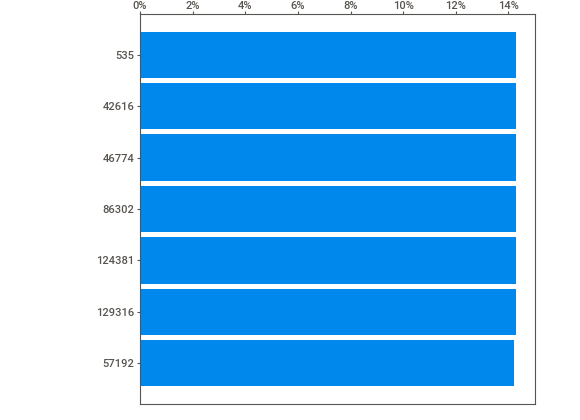
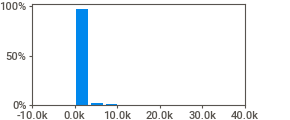
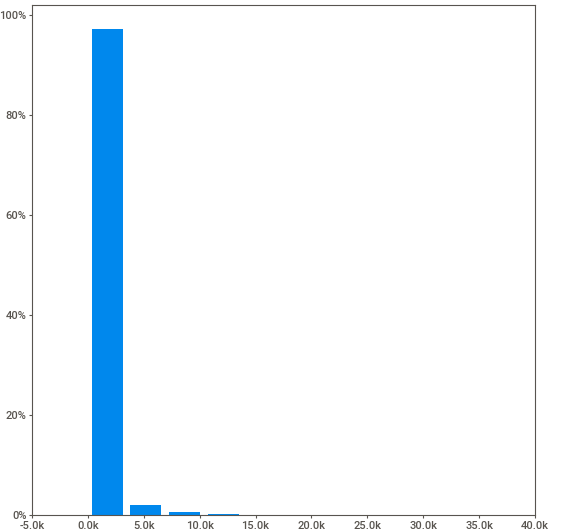
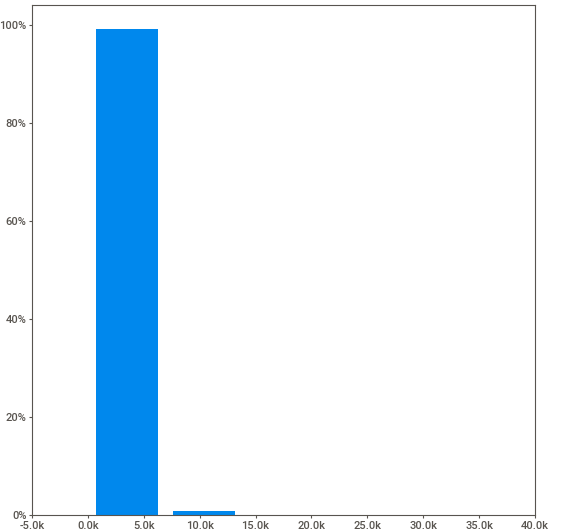
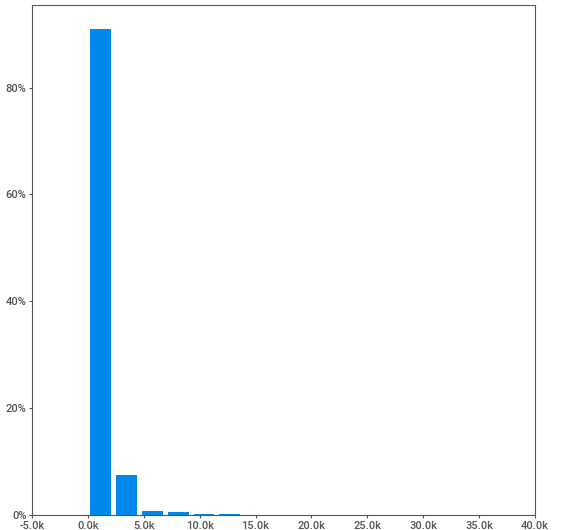
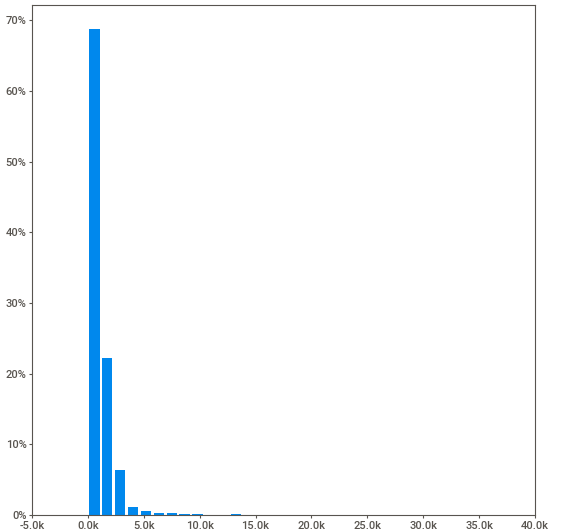
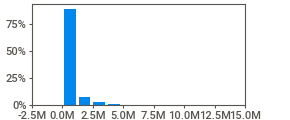
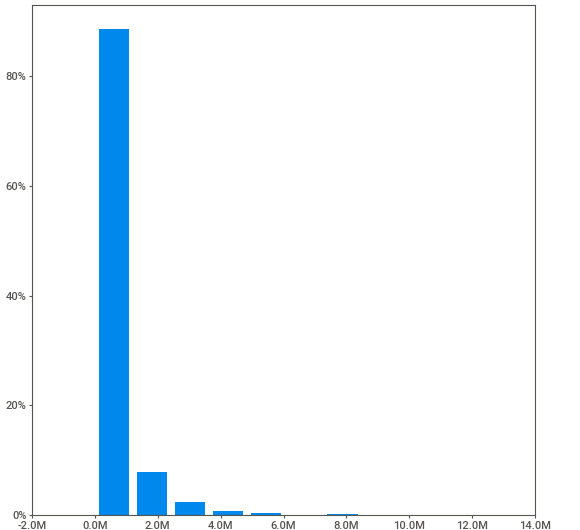
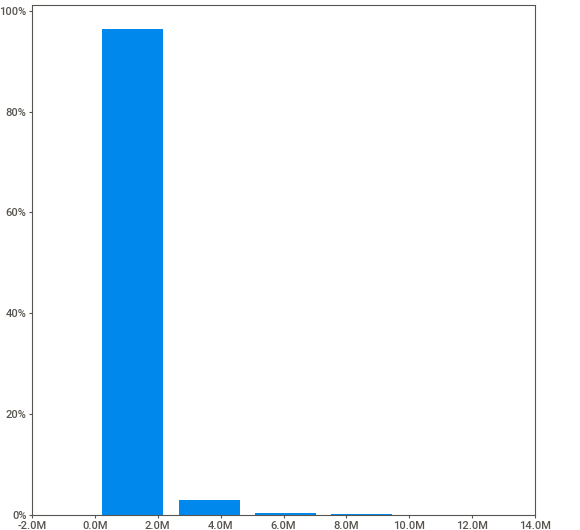
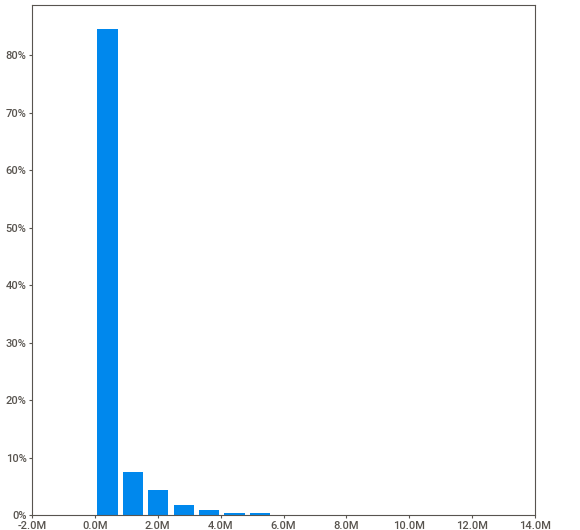
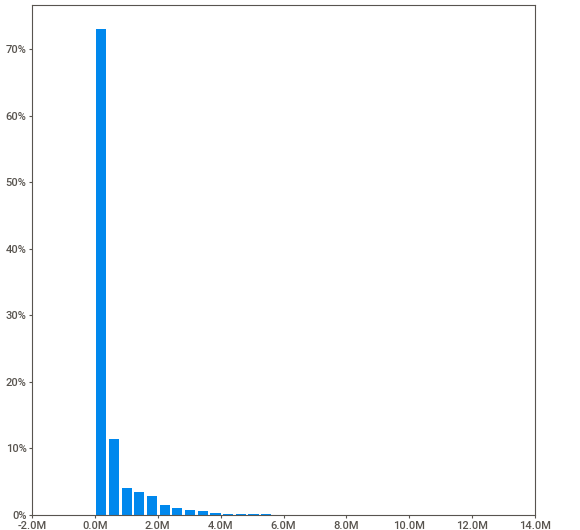
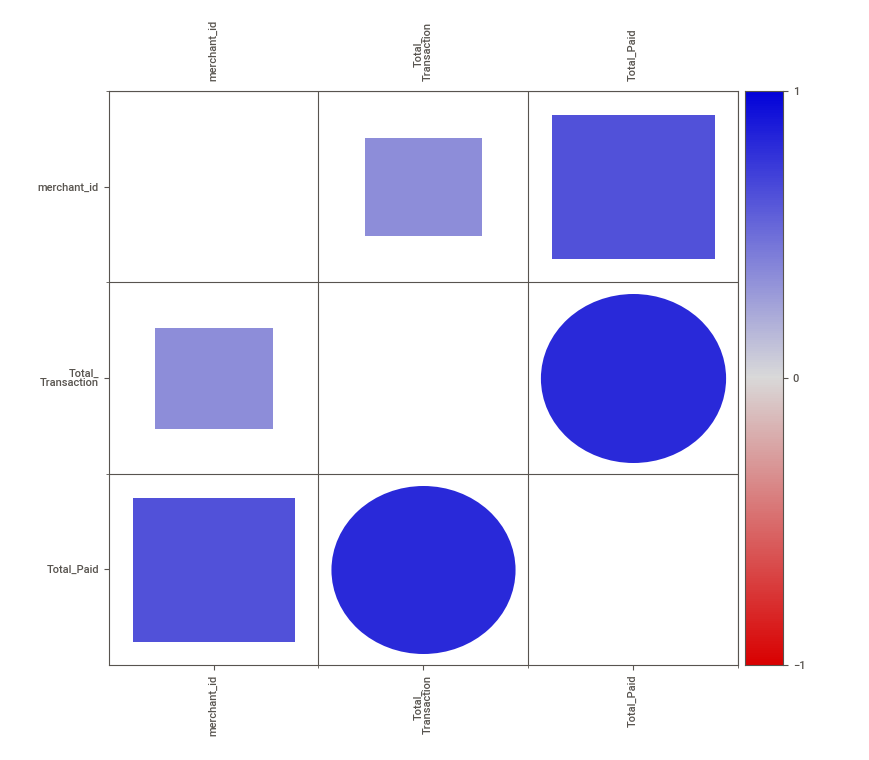
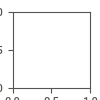

In [67]:
#analyzing the dataset
report_ = sv.analyze(df)
#display the report
# report_.show_html('Iyzico.html')
report_.show_notebook(w="100%", h="full")

In [68]:
df["transaction_date"].min() # Timestamp('2018-01-01 00:00:00')
df["transaction_date"].max() # Timestamp('2020-12-31 00:00:00')

Timestamp('2020-12-31 00:00:00')

In [69]:
df["merchant_id"].unique()

array([   535,  42616,  46774,  86302, 124381, 129316,  57192])

In [70]:
df.groupby("merchant_id").agg({"Total_Paid":"sum"})

,Total_Paid
merchant_id,
535,156601530.234
42616,354583091.808
46774,1567200341.286
57192,317337137.586
86302,2870446.716
124381,1158692543.973
129316,1555471.476


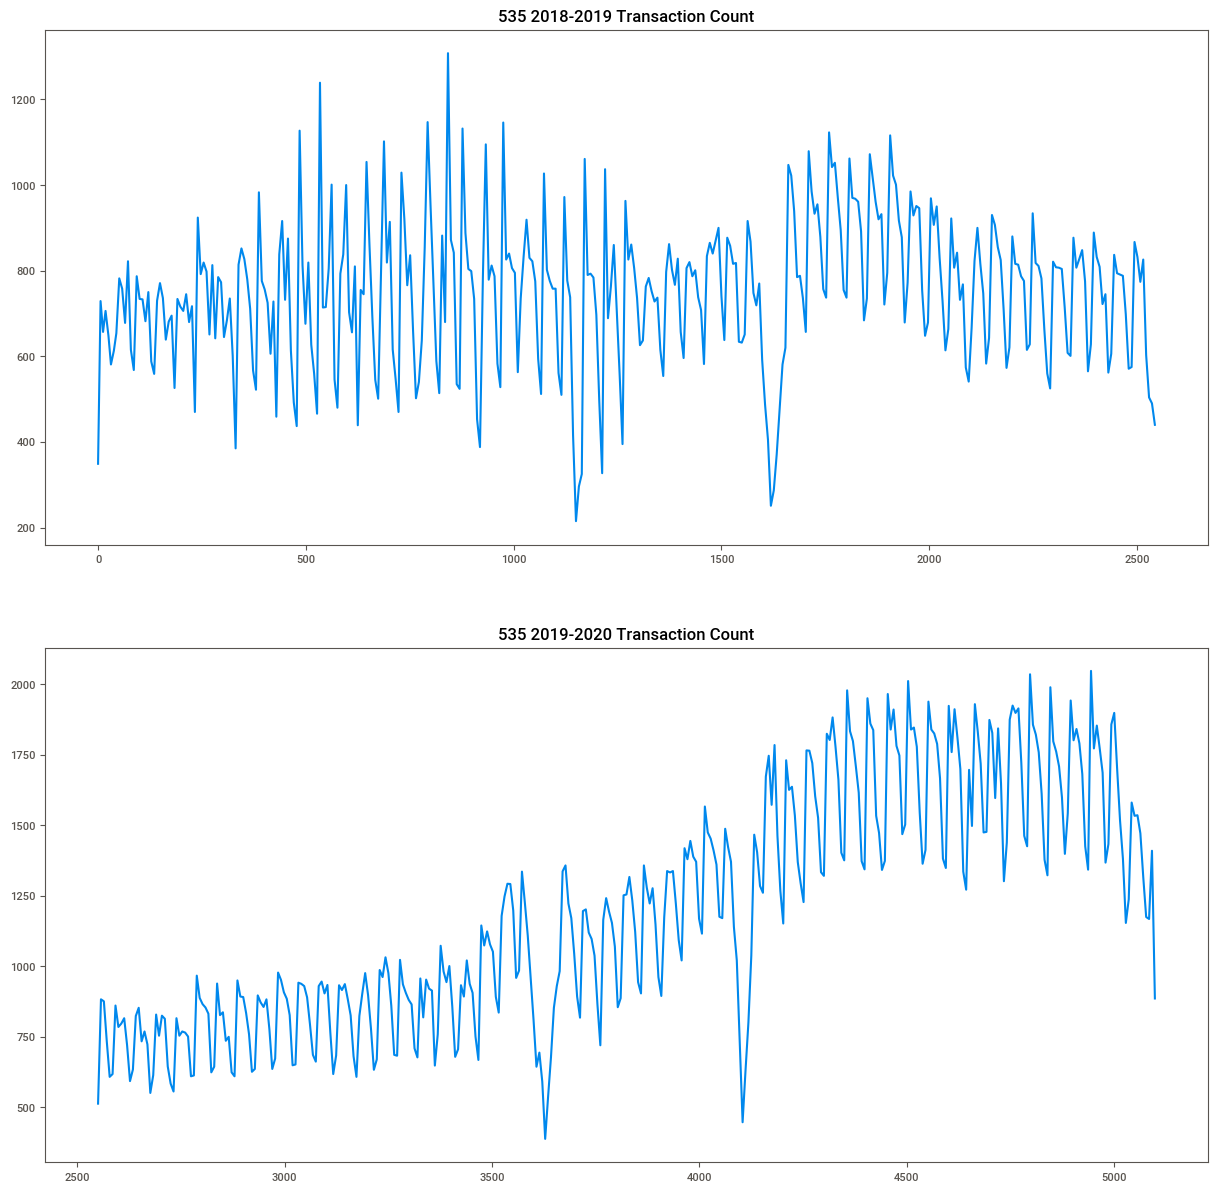

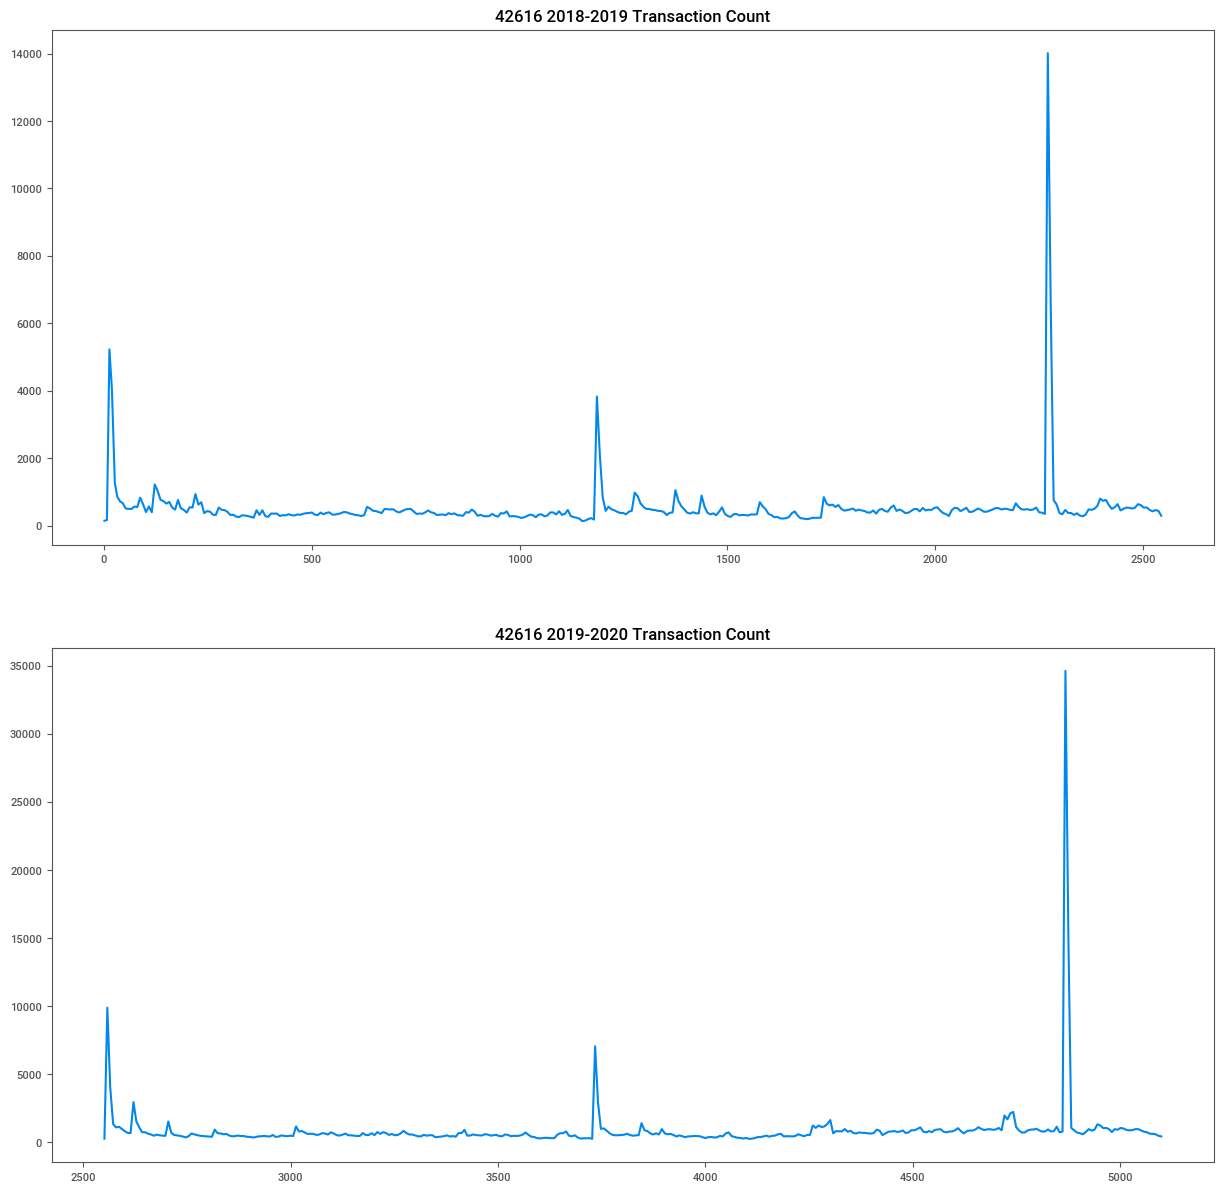

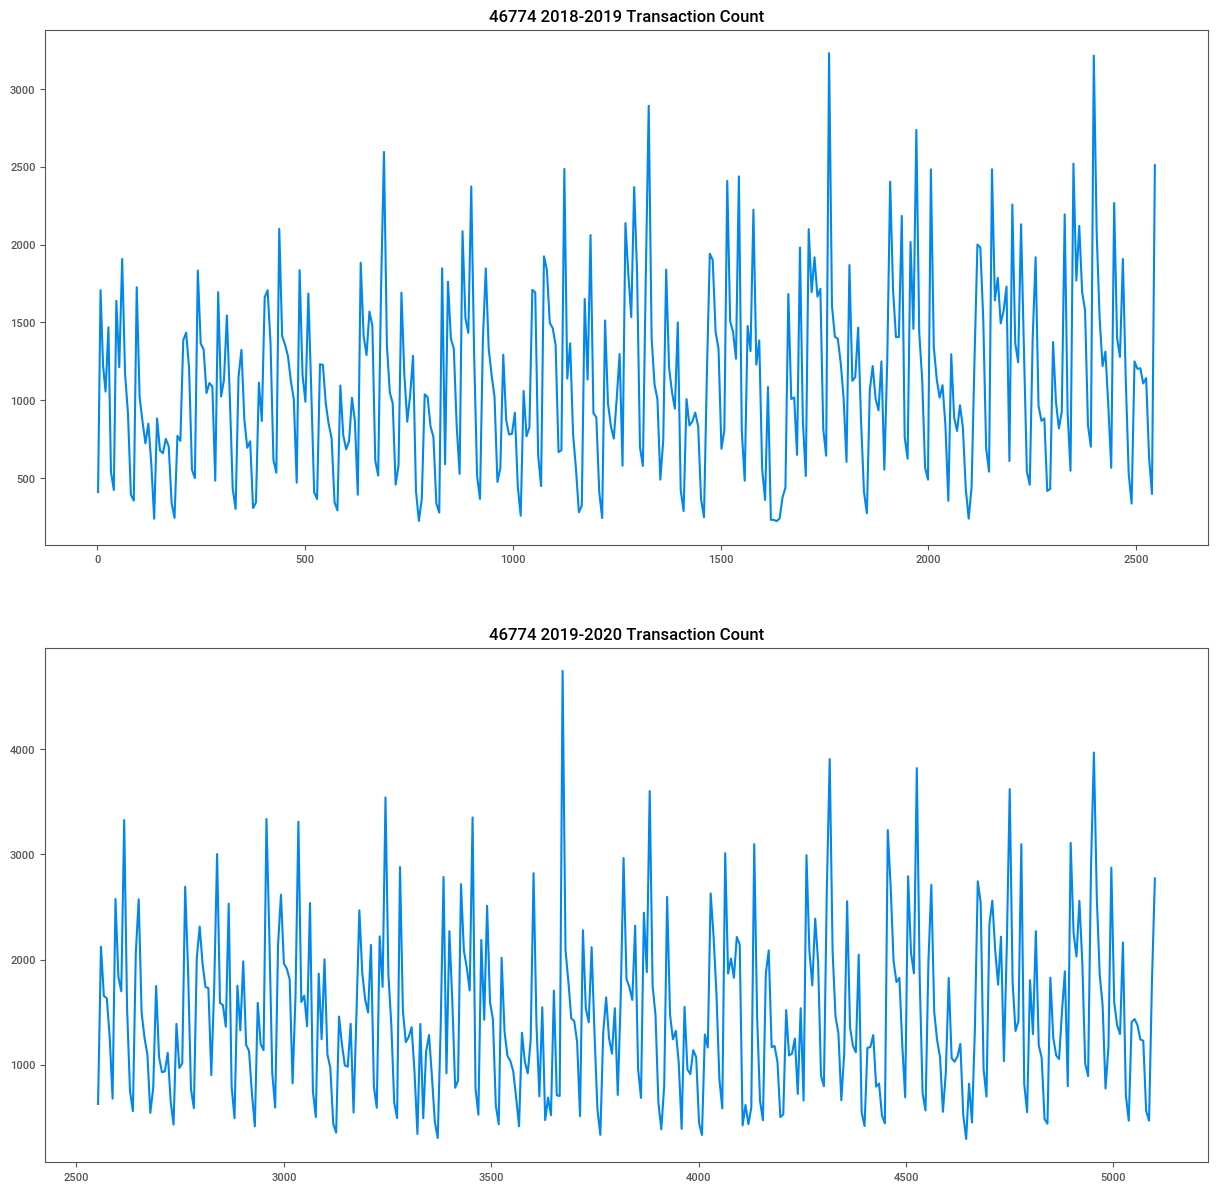

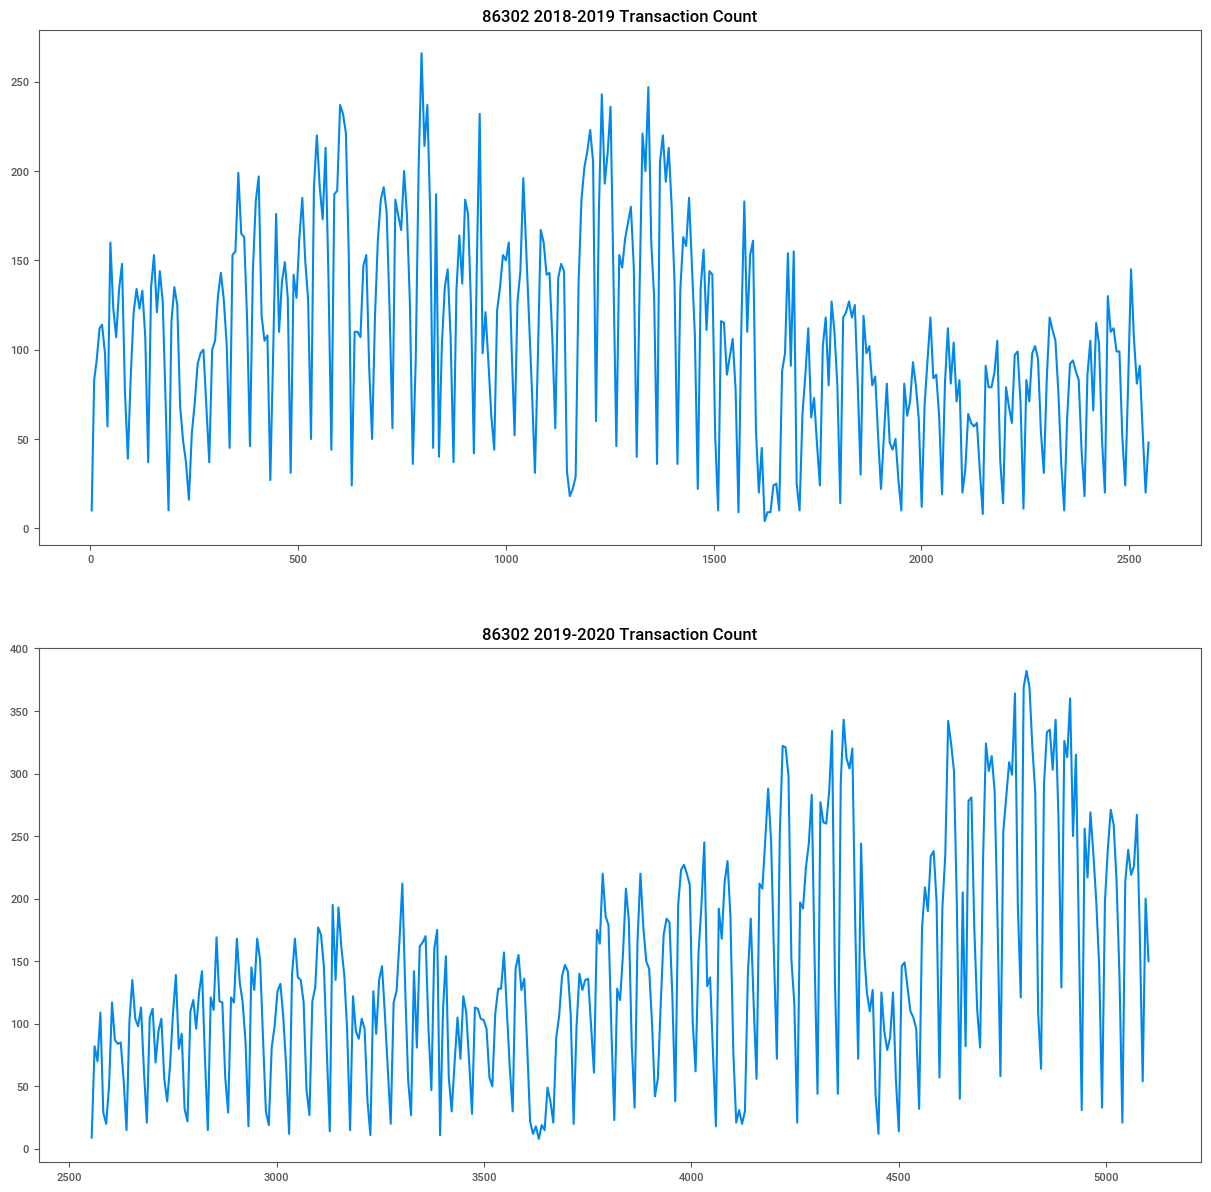

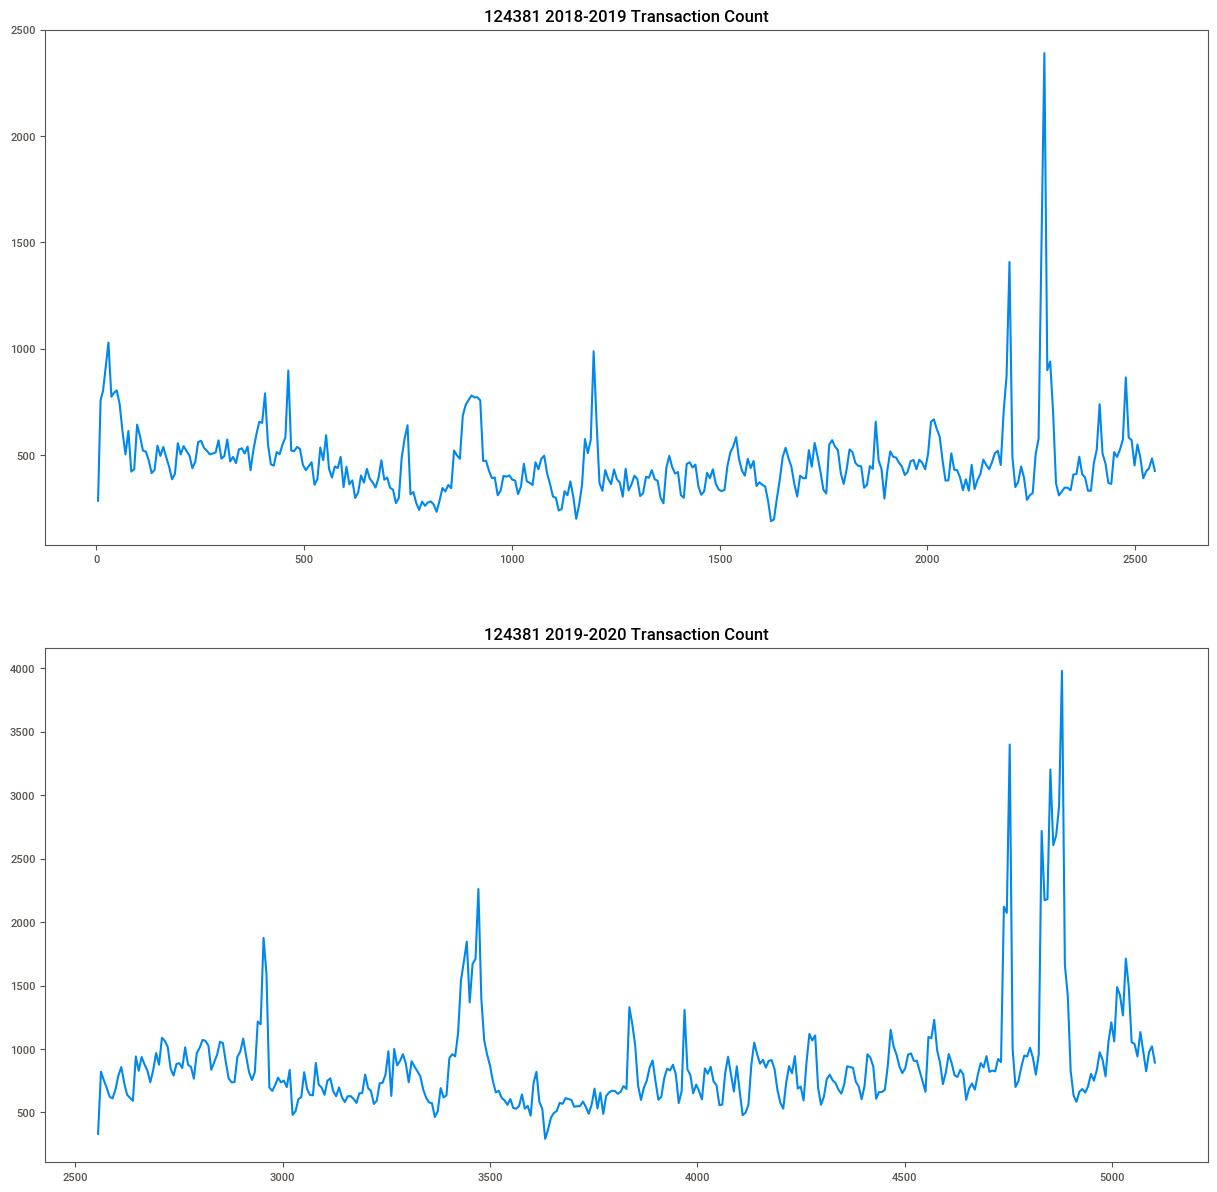

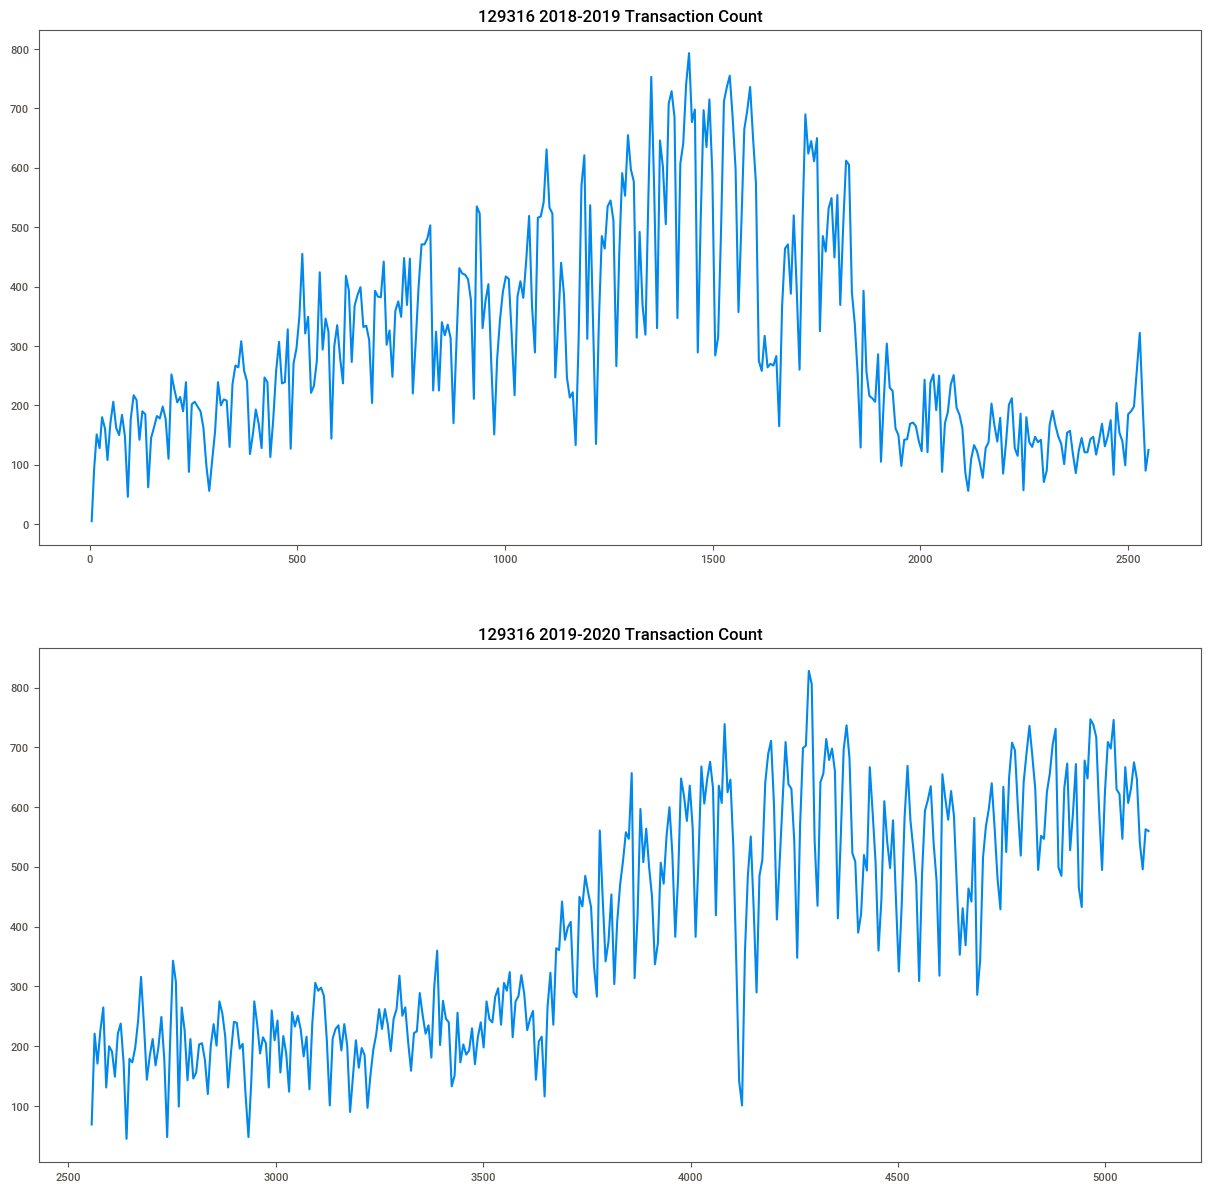

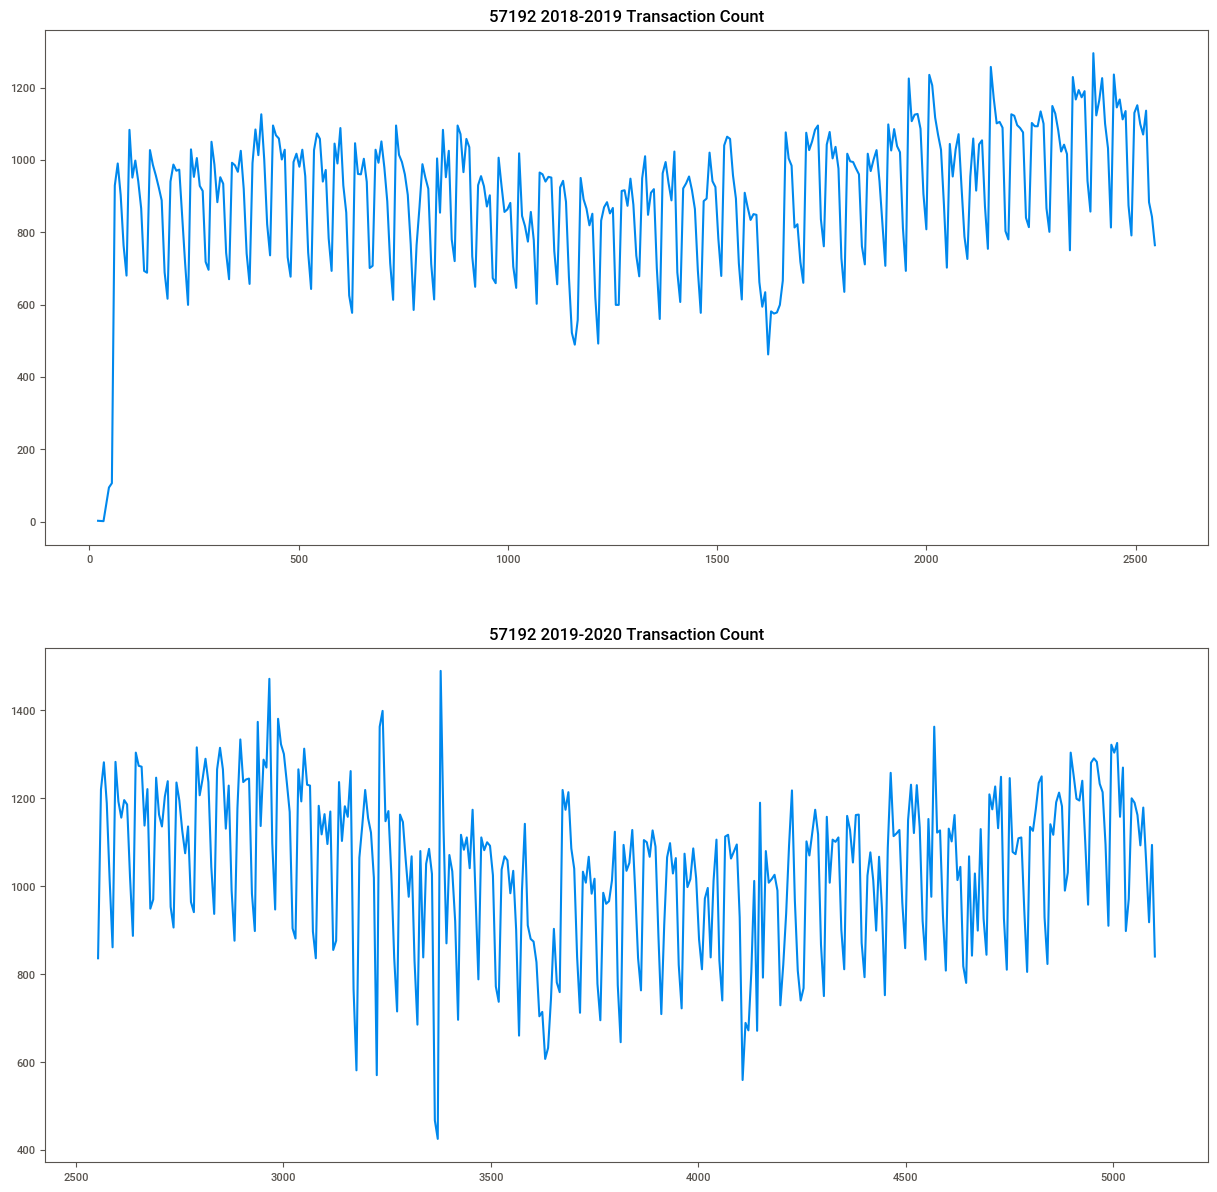

In [71]:
for id in df.merchant_id.unique():
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 1, 1, title = str(id) + ' 2018-2019 Transaction Count')
    df[(df.merchant_id == id) & ( df.transaction_date >= "2018-01-01" ) & (df.transaction_date < "2019-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.subplot(2, 1, 2,title = str(id) + ' 2019-2020 Transaction Count')
    df[(df.merchant_id == id) &( df.transaction_date >= "2019-01-01" )& (df.transaction_date < "2020-01-01")]["Total_Transaction"].plot()
    plt.xlabel('')
    plt.show()

In [72]:
def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.weekofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df
df = create_date_features(df, "transaction_date")
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0


In [73]:
df.groupby(["merchant_id","year","month"]).agg({"Total_Transaction": ["sum", "mean", "median"]})

Total_Transaction                  
                                     sum     mean   median
merchant_id year month                                    
535         2018 1                 20927  675.065  695.000
                 2                 20247  723.107  750.500
                 3                 22807  735.710  725.000
                 4                 22459  748.633  760.500
                 5                 24443  788.484  804.000
                 6                 20376  679.200  748.000
                 7                 23032  742.968  767.000
                 8                 21949  708.032  748.000
                 9                 26982  899.400  932.500
                 10                25516  823.097  830.000
                 11                22573  752.433  795.500
                 12                22091  712.613  774.000
            2019 1                 22586  728.581  753.000
                 2                 22041  787.179  832.000
                 3                 25314  816.581  883.000
                 4                 25862  862.067  899.500
                 5                 31060 1001.935  984.000
                 6                 28917  963.900 1009.500
                 7                 38444 1240.129 1254.000
                 8                 40455 1305.000 1369.000
                 9                 48960 1632.000 1685.000
                 10                52487 1693.129 1778.000
                 11                50443 1681.433 1719.000
                 12                48103 1551.710 1535.000
            2020 1                 47062 1518.129 1600.000
                 2                 47891 1651.414 1691.000
                 3                 41673 1344.290 1322.000
                 4                 27409  913.633  934.500
                 5                 39071 1260.355 1311.000
                 6                 51439 1714.633 1705.500
                 7                 52502 1693.613 1740.000
                 8                 57111 1842.290 1868.000
                 9                 63616 2120.533 2134.500
                 10                63652 2053.290 2077.000
                 11                55596 1853.200 1876.500
                 12                47629 1536.419 1574.000
42616       2018 1                 27226  878.258  564.000
                 2                 11125  397.321  338.500
                 3                 10525  339.516  336.000
                 4                 12337  411.233  409.000
                 5                  9785  315.645  300.000
                 6                 15570  519.000  340.000
                 7                 15684  505.935  434.000
                 8                 10211  329.387  311.000
                 9                 13652  455.067  452.000
                 10                13894  448.194  450.000
                 11                33834 1127.800  476.000
                 12                15559  501.903  496.000
            2019 1                 37578 1212.194  681.000
                 2                 14092  503.286  466.000
                 3                 18545  598.226  567.000
                 4                 16869  562.300  543.000
                 5                 16354  527.548  509.000
                 6                 24531  817.700  527.000
                 7                 17455  563.065  518.000
                 8                 14074  454.000  446.000
                 9                 26056  868.533  808.000
                 10                26816  865.032  868.000
                 11                79683 2656.100  950.500
                 12                26731  862.290  896.000
            2020 1                 73770 2379.677 1713.000
                 2                 33772 1164.552 1037.000
                 3                 37953 1224.290  962.000
                 4                 39516 1317.200 1294.000
                 5                 69971 2257.129 2296.000
           

In [74]:
df.groupby(["merchant_id","year","month"]).agg({"Total_Paid": ["sum", "mean", "median"]})

Total_Paid                        
                                 sum        mean      median
merchant_id year month                                      
535         2018 1       2091231.810   67459.091   71088.660
                 2       2060521.056   73590.038   73345.545
                 3       2371568.274   76502.202   71045.640
                 4       2504558.754   83485.292   83215.548
                 5       2831761.170   91347.135   90838.422
                 6       2433137.958   81104.599   84910.374
                 7       2741248.350   88427.366   89439.408
                 8       2724770.016   87895.807   91272.600
                 9       3130433.640  104347.788  105952.887
                 10      3187022.904  102807.190  106419.402
                 11      2969292.870   98976.429  100661.193
                 12      2897518.086   93468.325   98468.460
            2019 1       3012663.546   97182.695  100325.430
                 2       2913564.600  104055.879  106919.100
                 3       3653312.400  117848.787  121570.200
                 4       3825828.000  127527.600  130296.600
                 5       4522995.000  145903.065  144327.600
                 6       3733479.000  124449.300  131012.100
                 7       4807756.800  155088.929  154940.400
                 8       5183447.400  167207.981  171651.600
                 9       5772501.000  192416.700  187962.300
                 10      6200688.600  200022.213  208414.800
                 11      5731187.400  191039.580  191918.700
                 12      5389331.400  173849.400  181364.400
            2020 1       5540085.000  178712.419  181672.200
                 2       5679129.600  195832.055  196333.200
                 3       5046521.400  162791.013  165427.200
                 4       2651133.600   88371.120   90406.800
                 5       4050770.400  130670.013  134643.600
                 6       5982942.600  199431.420  197161.200
                 7       6654499.200  214661.265  218934.000
                 8       7193736.000  232056.000  242809.200
                 9       7417445.400  247248.180  250673.400
                 10      7411237.200  239072.168  239193.000
                 11      6556854.600  218561.820  222322.500
                 12      5727355.200  184753.394  194108.400
42616       2018 1       5212777.500  168154.113  112042.386
                 2       2316265.344   82723.762   78970.725
                 3       2637676.206   85086.329   82773.486
                 4       3027473.946  100915.798   96668.316
                 5       2430841.824   78414.252   74222.712
                 6       3802119.642  126737.321   87413.139
                 7       3184093.764  102712.702   94726.710
                 8       2343697.452   75603.144   76631.922
                 9       3927060.072  130902.002  134526.258
                 10      4696554.564  151501.760  148425.246
                 11     11263872.258  375462.409  165139.416
                 12      5071378.950  163592.869  163948.194
            2019 1       9941119.974  320681.289  171874.602
                 2       3869385.714  138192.347  132440.868
                 3       5251799.592  169412.890  160338.798
                 4       4916282.382  163876.079  163696.698
                 5       4703155.254  151714.686  150107.760
                 6       6255960.642  208532.021  131722.560
                 7       4211590.518  135857.759  124185.114
                 8       4210738.794  135830.284  138070.116
                 9       8183844.036  272794.801  262108.260
                 10      9278034.048  299291.421  300125.106
                 11     27843664.266  928122.142  352620.693
                 12      9976568.508  321824.791  338991.804
            2020 1      21376806.138  689574.392  476729.010
                 2       9747831.960  336132.137  305927.928
                 3      10390797.936  335187.030  298221.876


# Lag/Shifted Features

In [75]:
#since lag features are created from our dependent variable, we need to add some random noise to prevent overfitting.
# keeping randomness
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

#lags for 3 month-prediction 
df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

In [76]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Rolling Means

In [77]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby("merchant_id")['Total_Transaction']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = roll_mean_features(df, [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])

# Exponentially Weighted Mean Features

In [78]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby("merchant_id")['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)
df.tail()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_92,sales_ewm_alpha_095_lag_178,sales_ewm_alpha_095_lag_179,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_181,sales_ewm_alpha_095_lag_182,sales_ewm_alpha_095_lag_359,sales_ewm_alpha_095_lag_360,sales_ewm_alpha_095_lag_361,sales_ewm_alpha_095_lag_449,sales_ewm_alpha_095_lag_450,sales_ewm_alpha_095_lag_451,sales_ewm_alpha_095_lag_539,sales_ewm_alpha_095_lag_540,sales_ewm_alpha_095_lag_541,sales_ewm_alpha_095_lag_629,sales_ewm_alpha_095_lag_630,sales_ewm_alpha_095_lag_631,sales_ewm_alpha_095_lag_720,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_92,sales_ewm_alpha_09_lag_178,sales_ewm_alpha_09_lag_179,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_181,sales_ewm_alpha_09_lag_182,sales_ewm_alpha_09_lag_359,sales_ewm_alpha_09_lag_360,sales_ewm_alpha_09_lag_361,sales_ewm_alpha_09_lag_449,sales_ewm_alpha_09_lag_450,sales_ewm_alpha_09_lag_451,sales_ewm_alpha_09_lag_539,sales_ewm_alpha_09_lag_540,sales_ewm_alpha_09_lag_541,sales_ewm_alpha_09_lag_629,sales_ewm_alpha_09_lag_630,sales_ewm_alpha_09_lag_631,sales_ewm_alpha_09_lag_720,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_92,sales_ewm_alpha_08_lag_178,sales_ewm_alpha_08_lag_179,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_181,sales_ewm_alpha_08_lag_182,sales_ewm_alpha_08_lag_359,sales_ewm_alpha_08_lag_360,sales_ewm_alpha_08_lag_361,sales_ewm_alpha_08_lag_449,sales_ewm_alpha_08_lag_450,sales_ewm_alpha_08_lag_451,sales_ewm_alpha_08_lag_539,sales_ewm_alpha_08_lag_540,sales_ewm_alpha_08_lag_541,sales_ewm_alpha_08_lag_629,sales_ewm_alpha_08_lag_630,sales_ewm_alpha_08_lag_631,sales_ewm_alpha_08_lag_720,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_92,sales_ewm_alpha_07_lag_178,sales_ewm_alpha_07_lag_179,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_181,sales_ewm_alpha_07_lag_182,sales_ewm_alpha_07_lag_359,sales_ewm_alpha_07_lag_360,sales_ewm_alpha_07_lag_361,sales_ewm_alpha_07_lag_449,sales_ewm_alpha_07_lag_450,sales_ewm_alpha_07_lag_451,sales_ewm_alpha_07_lag_539,sales_ewm_alpha_07_lag_540,sales_ewm_alpha_07_lag_541,sales_ewm_alpha_07_lag_629,sales_ewm_alpha_07_lag_630,sales_ewm_alpha_07_lag_631,sales_ewm_alpha_07_lag_720,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_92,sales_ewm_alpha_05_lag_178,sales_ewm_alpha_05_lag_179,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_181,sales_ewm_alpha_05_lag_182,sales_ewm_alpha_05_lag_359,sales_ewm_alpha_05_lag_360,sales_ewm_alpha_05_lag_361,sales_ewm_alpha_05_lag_449,sales_ewm_alpha_05_lag_450,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_a

## Black Friday - Summer Solstice

In [79]:
df["is_black_friday"] = 0
df.loc[df["transaction_date"].isin(["2018-11-22","2018-11-23","2019-11-29","2019-11-30"]) ,"is_black_friday"]=1

df["is_summer_solstice"] = 0
df.loc[df["transaction_date"].isin(["2018-06-19","2018-06-20","2018-06-21","2018-06-22",
                                    "2019-06-19","2019-06-20","2019-06-21","2019-06-22",]) ,"is_summer_solstice"]=1

In [82]:
df = pd.get_dummies(df, columns=['merchant_id','day_of_week', 'month'])
df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)

# Custom Cost Function

In [91]:
# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# Time-Based Validation Sets

In [87]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#
train = df.loc[(df["transaction_date"] < "2020-10-01"), :]

# 
val = df.loc[(df["transaction_date"] >= "2020-10-01"), :]

cols = [col for col in train.columns if col not in ['transaction_date', 'id', "Total_Transaction","Total_Paid", "year" ]]

Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

In [88]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 212), (644,), (644, 212))

# LGBM Model

In [89]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [92]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009754 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.292839	training's SMAPE: 28.0769	valid_1's l1: 0.285602	valid_1's SMAPE: 27.2484
[200]	training's l1: 0.238676	training's SMAPE: 23.1016	valid_1's l1: 0.22448	valid_1's SMAPE: 21.6213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's l1: 0.218851	training's SMAPE: 21.2646	valid_1's l1: 0.210002	valid_1's SMAPE: 20.3352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

20.335215353076936

# Important Features

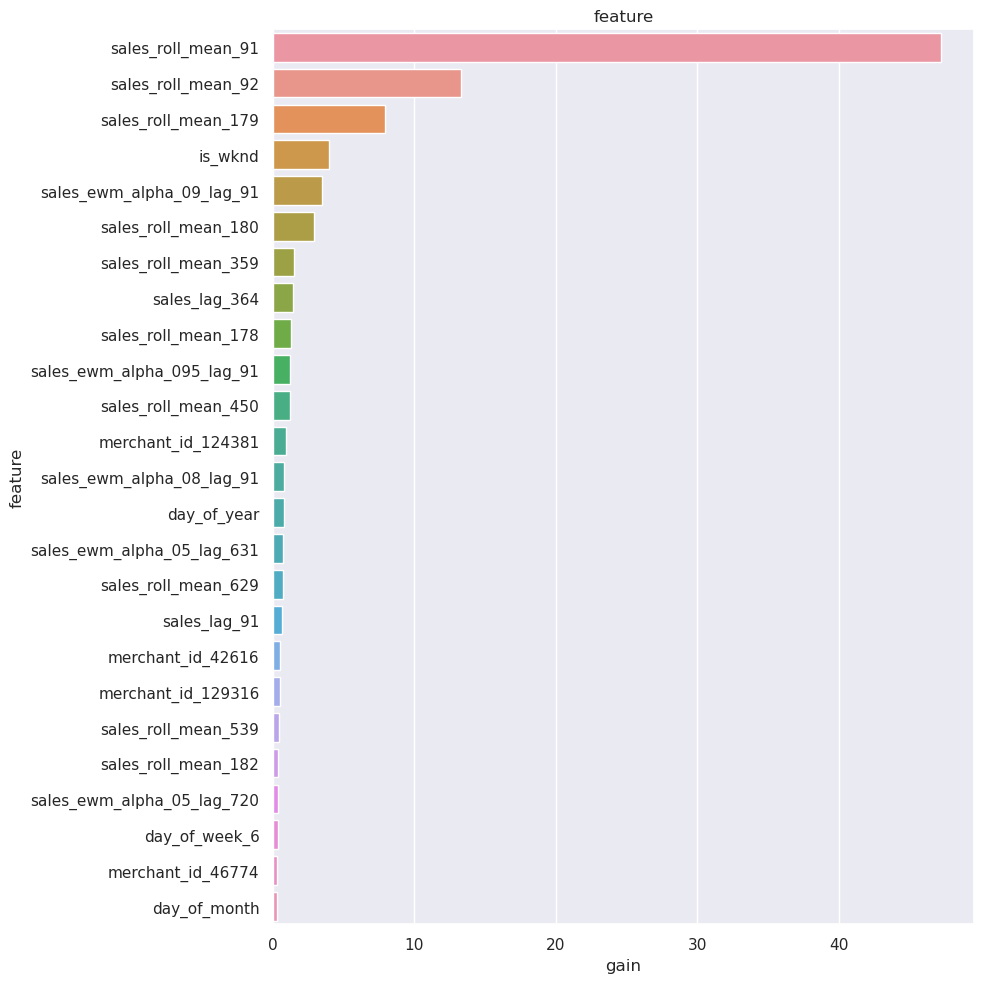

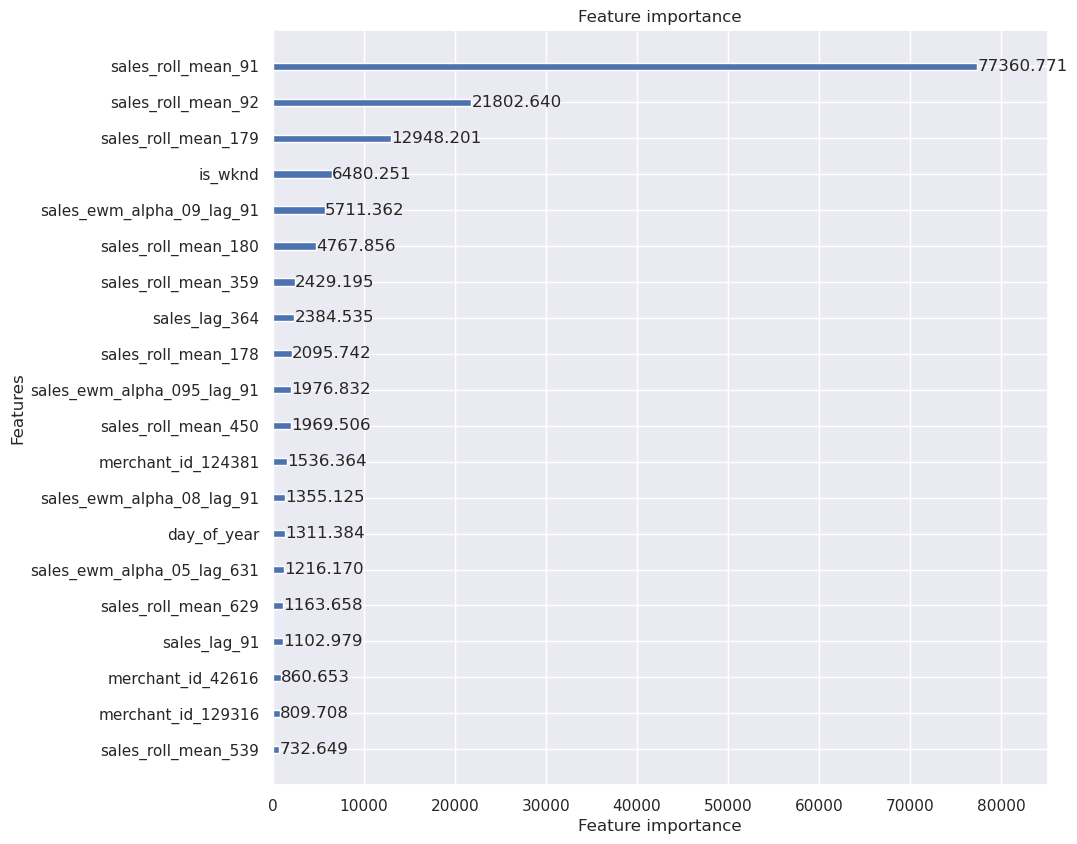

In [93]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp


plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()